In [1]:
!pip install pyqubo -q
!pip install seaborn -q

In [1]:
import json
import os
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import seaborn as sns
import time
import math
import numpy as np
import statistics as stats
from pyqubo import Array, Constraint, Placeholder

%matplotlib inline

In [2]:
def ImportImputJSON(fileName):
    columns_path = os.path.join('json', fileName, 'columns.json')
    table_path = os.path.join('json', fileName, 'Table.json')

    if not os.path.exists(columns_path) or not os.path.exists(table_path):
        print("Error: Files not found.")
        return None, None
    
    with open(columns_path) as f:
        columns = json.load(f)

    with open(table_path) as f:
        Table = json.load(f)

    return columns, Table

In [3]:
from qiskit import QuantumCircuit, Aer
from qiskit.circuit import Parameter

def blackbox_obj(solution, columns, Gce):
    solution_array = list(map(int, solution))

    obj = 0
    
    for i in range(len(Gce)):
        note = 0
        for j in range(len(columns)):
            note += (Gce[i][j] * solution_array[j])
        obj += ((note-1)**2)
    return obj

In [4]:
def compute_expectation(counts, columns, Gce):
    avg = 0
    sum_count = 0
    for bit_string, count in counts.items():
        obj = blackbox_obj(bit_string, columns, Gce)
        avg += obj * count
        sum_count += count
    return avg/sum_count

In [5]:
def create_qaoa_circ(columns, Gce, theta):
    nqubits = len(columns)
    n_layers = len(theta)//2
    beta = theta[:n_layers]
    gamma = theta[n_layers:]
    
    qc = QuantumCircuit(nqubits)

    qc.h(range(nqubits))

    for layer_index in range(n_layers):
        for i in range(len(Gce)):
            for j in range(len(Gce[i])):
                qc.rz(gamma[layer_index] * Gce[i][j], j)
        for qubit in range(nqubits):
            qc.rx(2 * beta[layer_index], qubit)
        
    qc.measure_all()
    return qc

In [6]:
def get_expectation(columns, Gce, shots=512):
    backend = Aer.get_backend('qasm_simulator')
    backend.shots = shots
    
    def execute_circ(theta):
        qc = create_qaoa_circ(columns, Gce, theta)
        counts = backend.run(qc, seed_simulator=10, nshots=512).result().get_counts()
        return compute_expectation(counts, columns, Gce)
    
    return execute_circ

In [12]:
columns, Gce = ImportImputJSON('test')
column = []
for i, row in enumerate(Gce):
    indices = [idx for idx, val in enumerate(row) if val == 1]
    if len(indices) == 2:
        column.append((indices[0], indices[1]))

op_opt_time = time.time()
expectation = get_expectation(column, Gce)
res = scipy.optimize.minimize(expectation,
               [2.0, 1.0],
               method='COBYLA')
ed_opt_time = time.time()
opt_time = ed_opt_time-op_opt_time

print(opt_time)

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: 3.9677734375
       x: [ 1.989e+00  2.031e+00  2.135e+00  3.008e+00]
    nfev: 45
   maxcv: 0.0

In [13]:
backend = Aer.get_backend('aer_simulator')
backend.shots = 512
from qiskit.visualization import plot_histogram
qc_res = create_qaoa_circ(column, Gce, res.x)
qc_res.draw()

┌───┐┌────────────┐  ┌───────┐     ┌───────┐     ┌───────┐   »
    q_0: ┤ H ├┤ Rz(2.1354) ├──┤ Rz(0) ├─────┤ Rz(0) ├─────┤ Rz(0) ├───»
         ├───┤├────────────┤  ├───────┤     ├───────┤     ├───────┤   »
    q_1: ┤ H ├┤ Rz(2.1354) ├──┤ Rz(0) ├─────┤ Rz(0) ├─────┤ Rz(0) ├───»
         ├───┤└─┬───────┬──┘┌─┴───────┴──┐  ├───────┤     ├───────┤   »
    q_2: ┤ H ├──┤ Rz(0) ├───┤ Rz(2.1354) ├──┤ Rz(0) ├─────┤ Rz(0) ├───»
         ├───┤  ├───────┤   ├────────────┤  ├───────┤     ├───────┤   »
    q_3: ┤ H ├──┤ Rz(0) ├───┤ Rz(2.1354) ├──┤ Rz(0) ├─────┤ Rz(0) ├───»
         ├───┤  ├───────┤   └─┬───────┬──┘┌─┴───────┴──┐  ├───────┤   »
    q_4: ┤ H ├──┤ Rz(0) ├─────┤ Rz(0) ├───┤ Rz(2.1354) ├──┤ Rz(0) ├───»
         ├───┤  ├───────┤     ├───────┤   ├────────────┤  ├───────┤   »
    q_5: ┤ H ├──┤ Rz(0) ├─────┤ Rz(0) ├───┤ Rz(2.1354) ├──┤ Rz(0) ├───»
         ├───┤  ├───────┤     ├───────┤   └─┬───────┬──┘┌─┴───────┴──┐»
    q_6: ┤ H ├──┤ Rz(0) ├─────┤ Rz(0) ├─────┤ Rz(0) ├───┤ Rz(2.1354) ├»
         ├───┤  ├───────┤     ├───────┤     ├───────┤   ├────────────┤»
    q_7: ┤ H ├──┤ Rz(0) ├─────┤ Rz(0) ├─────┤ Rz(0) ├───┤ Rz(2.1354) ├»
         ├───┤  ├───────┤     ├───────┤     ├───────┤   └─┬───────┬──┘»
    q_8: ┤ H ├──┤ Rz(0) ├─────┤ Rz(0) ├─────┤ Rz(0) ├─────┤ Rz(0) ├───»
         ├───┤  ├───────┤     ├───────┤     ├───────┤     ├───────┤   »
    q_9: ┤ H ├──┤ Rz(0) ├─────┤ Rz(0) ├─────┤ Rz(0) ├─────┤ Rz(0) ├───»
         ├───┤  ├───────┤     ├───────┤     ├───────┤     ├───────┤   »
   q_10: ┤ H ├──┤ Rz(0) ├─────┤ Rz(0) ├─────┤ Rz(0) ├─────┤ Rz(0) ├───»
         ├───┤  ├───────┤     ├───────┤     ├───────┤     ├───────┤   »
   q_11: ┤ H ├──┤ Rz(0) ├─────┤ Rz(0) ├─────┤ Rz(0) ├─────┤ Rz(0) ├───»
         ├───┤  ├───────┤     ├───────┤     ├───────┤     ├───────┤   »
   q_12: ┤ H ├──┤ Rz(0) ├─────┤ Rz(0) ├─────┤ Rz(0) ├─────┤ Rz(0) ├───»
         ├───┤  ├───────┤     ├───────┤     ├───────┤     ├───────┤   »
   q_13: ┤ H ├──┤ Rz(0) ├─────┤ Rz(0) ├─────┤ Rz(0) ├─────┤ Rz(0) ├───»
         ├───┤  ├───────┤     ├───────┤     ├───────┤     ├───────┤   »
   q_14: ┤ H ├──┤ Rz(0) ├─────┤ Rz(0) ├─────┤ Rz(0) ├─────┤ Rz(0) ├───»
         ├───┤  ├───────┤     ├───────┤     ├───────┤     ├───────┤   »
   q_15: ┤ H ├──┤ Rz(0) ├─────┤ Rz(0) ├─────┤ Rz(0) ├─────┤ Rz(0) ├───»
         └───┘  └───────┘     └───────┘     └───────┘     └───────┘   »
meas: 16/═════════════════════════════════════════════════════════════»
                                                                      »
«           ┌───────┐     ┌───────┐     ┌───────┐     ┌───────┐   »
«    q_0: ──┤ Rz(0) ├─────┤ Rz(0) ├─────┤ Rz(0) ├─────┤ Rz(0) ├───»
«           ├───────┤     ├───────┤     ├───────┤     ├───────┤   »
«    q_1: ──┤ Rz(0) ├─────┤ Rz(0) ├─────┤ Rz(0) ├─────┤ Rz(0) ├───»
«           ├───────┤     ├───────┤     ├───────┤     ├───────┤   »
«    q_2: ──┤ Rz(0) ├─────┤ Rz(0) ├─────┤ Rz(0) ├─────┤ Rz(0) ├───»
«           ├───────┤     ├───────┤     ├───────┤     ├───────┤   »
«    q_3: ──┤ Rz(0) ├─────┤ Rz(0) ├─────┤ Rz(0) ├─────┤ Rz(0) ├───»
«           ├───────┤     ├───────┤     ├───────┤     ├───────┤   »
«    q_4: ──┤ Rz(0) ├─────┤ Rz(0) ├─────┤ Rz(0) ├─────┤ Rz(0) ├───»
«           ├───────┤     ├───────┤     ├───────┤     ├───────┤   »
«    q_5: ──┤ Rz(0) ├─────┤ Rz(0) ├─────┤ Rz(0) ├─────┤ Rz(0) ├───»
«           ├───────┤     ├───────┤     ├───────┤     ├───────┤   »
«    q_6: ──┤ Rz(0) ├─────┤ Rz(0) ├─────┤ Rz(0) ├─────┤ Rz(0) ├───»
«           ├───────┤     ├───────┤     ├───────┤     ├───────┤   »
«    q_7: ──┤ Rz(0) ├─────┤ Rz(0) ├─────┤ Rz(0) ├─────┤ Rz(0) ├───»
«         ┌─┴───────┴──┐  ├───────┤     ├───────┤     ├───────┤   »
«    q_8: ┤ Rz(2.1354) ├──┤ Rz(0) ├─────┤ Rz(0) ├─────┤ Rz(0) ├───»
«         ├────────────┤  ├───────┤     ├───────┤     ├───────┤   »
«    q_9: ┤ Rz(2.1354) ├──┤ Rz(0) ├─────┤ Rz(0) ├─────┤ Rz(0) ├───»
«         └─┬───────┬──┘┌─┴───────┴──┐  ├───────┤     ├───────┤   »
«   q_10: ──┤ Rz(0) ├───┤ Rz(2.1354) ├──┤ Rz(0) ├─────┤ Rz(0)

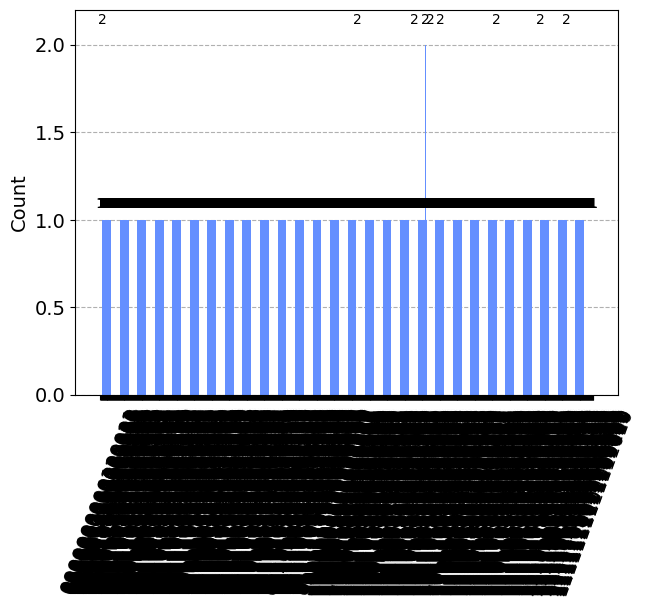

In [14]:
qc_res = create_qaoa_circ(column, Gce, res.x)
counts = backend.run(qc_res, seed_simulator=10).result().get_counts()
plot_histogram(counts)

In [10]:
print(counts)

{'110': 1, '011': 2, '010': 1021}
